<a href="https://colab.research.google.com/github/camerse/Pytorch_image_classification_flowers/blob/master/flower_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch torchvision fastai --upgrade

     |████████████████████████████████| 748.9MB 24kB/s 
     |████████████████████████████████| 8.8MB 49.3MB/s 
Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (1.0.57)
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0


In [0]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import fastai
from fastai.vision import *

In [0]:
path = untar_data(URLs.FLOWERS)

In [0]:
os.listdir(str(path))
path

PosixPath('/root/.fastai/data/oxford-102-flowers')

In [0]:
with open(str(path)+'/train.txt', 'r') as f:
    c = f.read()

In [0]:
with open(str(path)+'/valid.txt', 'r') as f:
    v = f.read()

In [0]:
with open(str(path)+'/test.txt', 'r') as f:
    te = f.read()

In [0]:
lbf = c.split('\n')
lbfn = [f.split() for f in lbf]

lbfv = v.split('\n')
lbfvn = [f.split() for f in lbfv]

val_fn = [f[0] for f in lbfvn if len(f) > 0]

tlb = te.split('\n')
tlbfn = [f.split() for f in tlb]

test = pd.DataFrame()
test['img'] = tlbfn

train_list = lbfn+lbfvn

df = pd.DataFrame()
df['l'] = train_list
df['ll'] = df['l'].apply(len)
df = df[df['ll']>0].copy()
df['path'] = df['l'].apply(lambda x: x[0])
df['target'] = df['l'].apply(lambda x: x[1])
df = df[['path', 'target']].copy()

tlb = te.split('\n')
tlbfn = [f.split() for f in tlb]

test = pd.DataFrame()
test['l'] = tlbfn
test['ll'] = test['l'].apply(len)
test = test[test['ll']>0].copy()
test['path'] = test['l'].apply(lambda x: x[0])
test['target'] = test['l'].apply(lambda x: x[1])
test = test[['path', 'target']].copy()

In [0]:
df.shape, test.shape

((2040, 2), (6149, 2))

In [0]:
test1 = test[:2000].copy()
ddf = df.append(test1).reset_index(drop=True)
test2 = test[2000:].copy()

In [0]:
open_image(path/df['path'].loc[1]).data.shape

torch.Size([3, 638, 500])

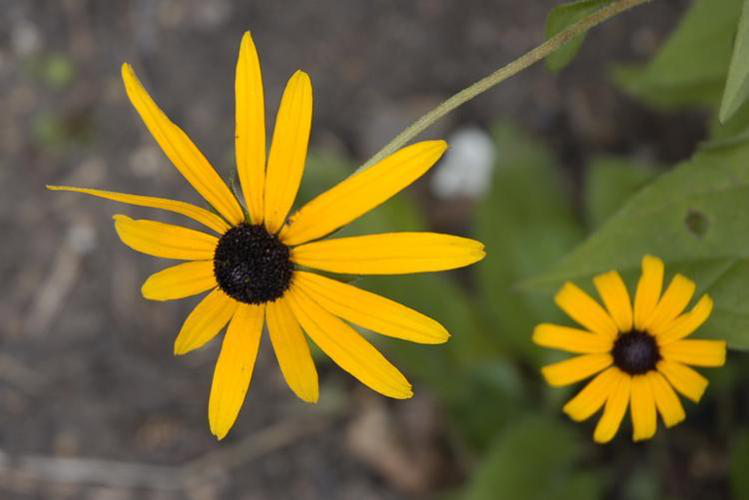

In [0]:
open_image(path/df['path'].loc[100])

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=5.0, max_zoom=0.2,
                      max_lighting=0.15, max_warp=0.02)

TFMS are transformations, they are part of "augmentation" which is used in AI, specifically for image classification.

Imagenet is a dataset that is used as an industry standard. Typically models are trained on imagenet, then you take parameters that were calibrated on image net and apply to your dataset. Then the model is applied/trained on your dataset just for the last layer.

In [0]:
data = (ImageList.from_df(df=df,cols='path',path=path)
        .split_by_rand_pct(0.2)
        .label_from_df('target')
        .transform(tfms, size=320)
        .databunch(bs=16,num_workers=2)
        .normalize(imagenet_stats)
       )

In [0]:
import torchvision.models as tvm

In [0]:
learn = cnn_learner(data,
                   models.resnet18,
                   metrics=[accuracy]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [0]:
learn.model

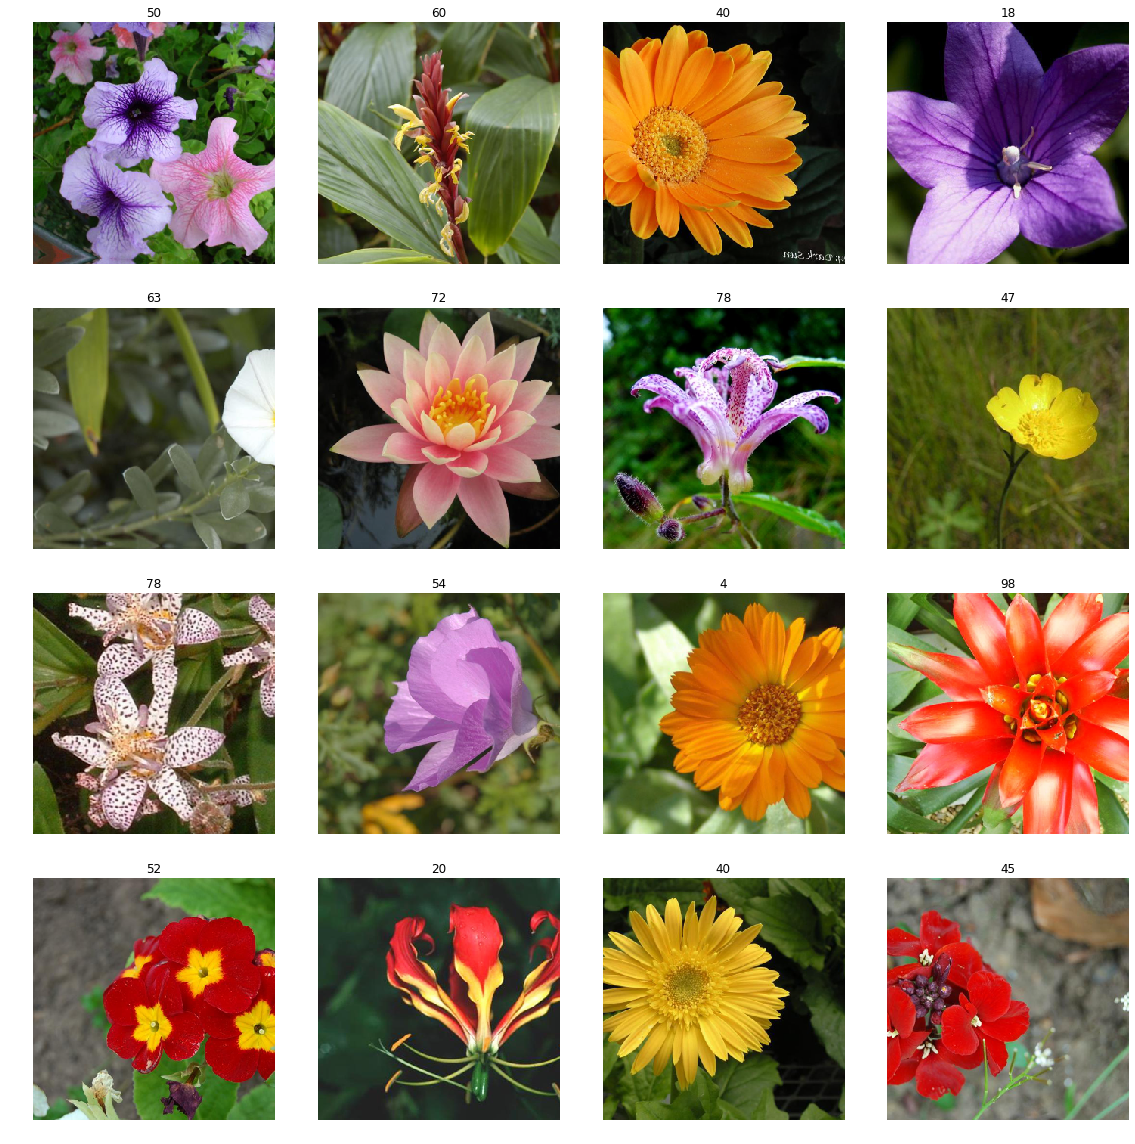

In [0]:
learn.data.show_batch()

In [0]:
learn.fit_one_cycle(10, 1e-3)

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

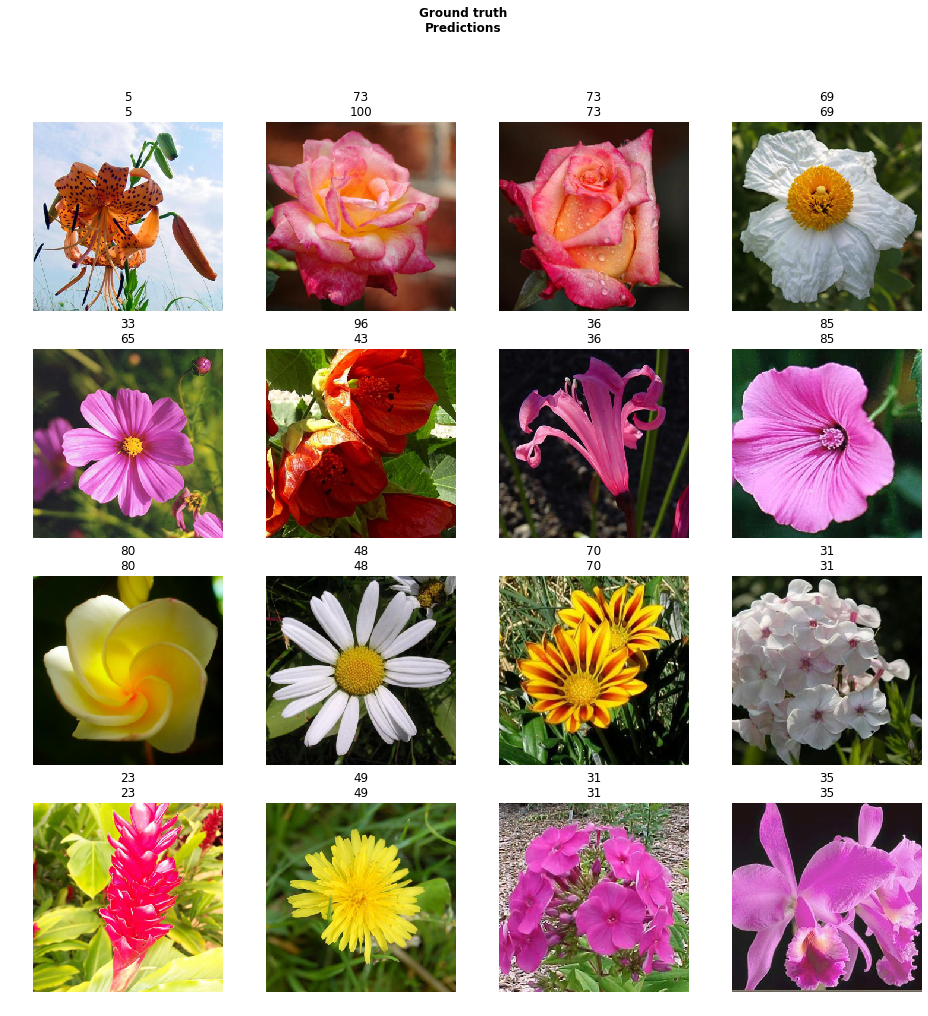

In [0]:
learn.show_results()

In [0]:
data_test = ImageList.from_df(df=test,cols='path',path=path)
learn.data.add_test(data_test)

In [0]:
preds, _ = learn.get_preds(DatasetType.Test)

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
prediction = preds.argmax(1)

In [0]:
test['target'] = test['target'].apply(int)

In [0]:
accuracy_score(prediction.numpy(),  test['target'])

0.1780777362172711

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

In [0]:
learn = learn.to_fp32()

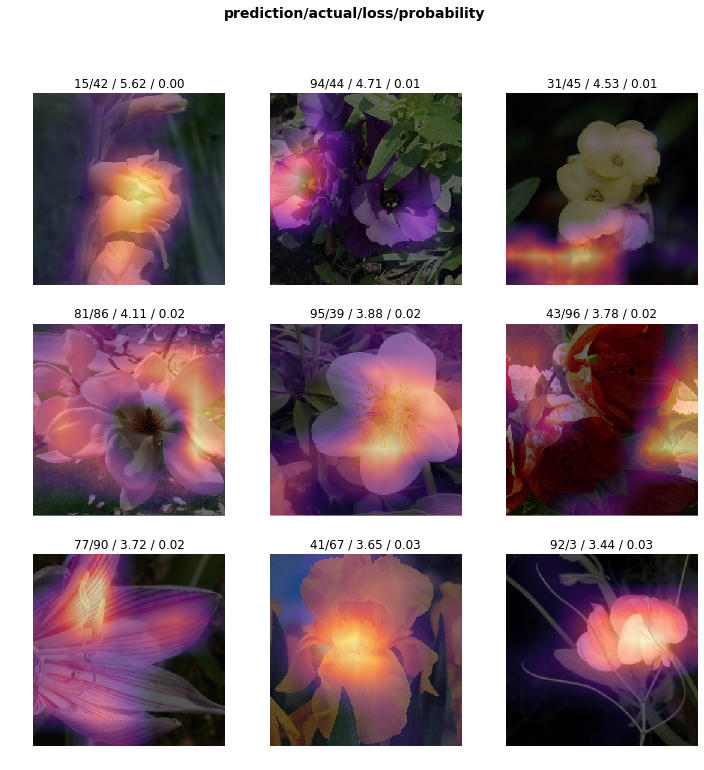

In [0]:
interp.plot_top_losses(9, figsize=(12,12), heatmap=True)

In [0]:
learn.data.c

102

In [0]:
trl = df['target'].tolist()

In [0]:
ttl = test['target'].tolist()

In [0]:
ll = ttl+trl

In [0]:
len(set(ll))

204

In [0]:
len(set(trl))

102

In [0]:
len(set(ttl))

102

In [0]:
test.loc[test.target.isin(df.target)]

path  target
0     jpg/image_06977.jpg      34
1     jpg/image_00800.jpg      80
2     jpg/image_05038.jpg      58
3     jpg/image_06759.jpg       0
4     jpg/image_01133.jpg      45
5     jpg/image_07982.jpg     100
6     jpg/image_04468.jpg      89
7     jpg/image_02363.jpg      42
8     jpg/image_01393.jpg      50
9     jpg/image_07216.jpg       6
10    jpg/image_08052.jpg      23
11    jpg/image_00102.jpg      76
12    jpg/image_03737.jpg      36
13    jpg/image_01232.jpg      73
14    jpg/image_00382.jpg      72
15    jpg/image_06786.jpg      20
16    jpg/image_03779.jpg      36
17    jpg/image_04217.jpg      51
18    jpg/image_02165.jpg      74
19    jpg/image_02188.jpg      74
20    jpg/image_02314.jpg      40
21    jpg/image_05497.jpg      86
22    jpg/image_04379.jpg      35
23    jpg/image_07452.jpg      93
24    jpg/image_05584.jpg      31
25    jpg/image_07909.jpg      99
26    jpg/image_04765.jpg      54
27    jpg/image_01849.jpg      77
28    jpg/image_01372.jpg      50
29    jpg/image_05274.jpg      27
...                   ...     ...
6119  jpg/image_02734.jpg      57
6120  jpg/image_04635.jpg      47
6121  jpg/image_04283.jpg      17
6122  jpg/image_04561.jpg      39
6123  jpg/image_07189.jpg       5
6124  jpg/image_00981.jpg      45
6125  jpg/image_06637.jpg       2
6126  jpg/image_04151.jpg      28
6127  jpg/image_01399.jpg      50
6128  jpg/image_07821.jpg      97
6129  jpg/image_07089.jpg       9
6130  jpg/image_01865.jpg      77
6131  jpg/image_05390.jpg      21
6132  jpg/image_02551.jpg      75
6133  jpg/image_02926.jpg      59
6134  jpg/image_01358.jpg      50
6135  jpg/image_04077.jpg      11
6136  jpg/image_03914.jpg      50
6137  jpg/image_01022.jpg      45
6138  jpg/image_02925.jpg      59
6139  jpg/image_00985.jpg      45
6140  jpg/image_06412.jpg       8
6141  jpg/image_07145.jpg      44
6142  jpg/image_00638.jpg      88
6143  jpg/image_07558.jpg      94
6144  jpg/image_08168.jpg      61
6145  jpg/image_07487.jpg      94
6146  jpg/image_04432.jpg      89
6147  jpg/image_02532.jpg      75
6148  jpg/image_00178.jpg      76

[6149 rows x 2 columns]